In [69]:
import numpy as np
# np.set_printoptions(suppress = True)
import torch
import argparse

import matplotlib.pyplot as plt
# import models
# from utils import calculate_stats

# conda install conda-forge::argparse

In [49]:
# Paula's calculate_stats function
def calculate_stats(X_train, y_train, X_test, y_test, args):

    # Overlapping columns are first 24 for y_train and last 24 for X_train
    means = np.mean(y_test[:, :24] + X_test[:, 8:], axis = 0)

    X_log_eps = log_transform(X_train)
    y_log_eps = log_transform(y_train)
    
    # so4 has much higher values
    # why are these 4 and 5 not 7?
    # These are 17, what are the others?
    so4 = np.concatenate((X_train[:,8], X_train[:,9], X_train[:,10], X_train[:,11], X_train[:,12]), axis = 0)
    bc = np.concatenate((X_train[:,13], X_train[:,14], X_train[:,15], X_train[:,16]), axis = 0)
    oc = np.concatenate((X_train[:,17], X_train[:,18], X_train[:,19], X_train[:,20]), axis = 0)
    # ORDER?!
    du = np.concatenate((X_train[:,21], X_train[:,24], X_train[:,22], X_train[:,23]), axis = 0)

    so4_mean = np.mean(so4)
    bc_mean = np.mean(bc)
    oc_mean = np.mean(oc)  
    du_mean = np.mean(du) 
    
    stats = {'xtrain_mean': np.mean(X_train, axis = 0),
            'xtrain_std': np.std(X_train, axis = 0),
            'ytrain_mean': np.mean(y_train, axis = 0), # this is now delta's
            'ytrain_std': np.std(y_train, axis = 0),
            'so4_mean': so4_mean,
            'bc_mean': bc_mean,
            'oc_mean': oc_mean,
            'du_mean': du_mean,
            'X_log_eps_mean': np.mean(X_log_eps, axis = 0),
            'X_log_eps_std': np.std(X_log_eps, axis = 0),
            'y_log_eps_mean': np.mean(y_log_eps, axis = 0),
            'y_log_eps_std': np.std(y_log_eps, axis = 0),
            'means': means # These are for test
            }
    
    global mu_y
    global si_y
    global mu_x
    global si_x
    
    mu_y = Variable(torch.Tensor(stats['ytrain_mean']), requires_grad = True).to(device)
    si_y = Variable(torch.Tensor(stats['ytrain_std']), requires_grad = True).to(device)
    mu_x = Variable(torch.Tensor(stats['xtrain_mean']), requires_grad = True).to(device)
    si_x = Variable(torch.Tensor(stats['xtrain_std']), requires_grad = True).to(device)
    return stats

In [50]:
# define full path 
path_to_data = "/home/kim/data/aerosols/aerosol_emulation_data/"

X_test = np.load(path_to_data + 'X_test.npy')
y_test = np.load(path_to_data + 'y_test.npy')

X_train = np.load(path_to_data + 'X_train.npy')
y_train = np.load(path_to_data + 'y_train.npy')

# Select the correct 24 columns
X_test_24 = X_test[:, 8:]
X_train_24 = X_train[:, 8:] 

y_test_24 = y_test[:, :24]
y_train_24 = y_train[:, :24]

# How much has it changes between x (at t = 0)  and y (at t = 1)
y_delta_train_24 = y_train_24 - X_train_24
y_delta_test_24 = y_test_24 - X_test_24

# Look at one instance of data

In [51]:
i = 1000
print(X_train_24[i, [0, 1, 2, 3, 4]])
print(y_train_24[i, [0, 1, 2, 3, 4]])
print(y_train_24[i, [0, 1, 2, 3, 4]] - X_train_24[i, [0, 1, 2, 3, 4]])

[    34.6611889    1508.99534109 306207.73492199 401794.78072114
     61.04572957]
[    34.65558446   1508.9734313  306207.68081635 401794.86232588
     61.04574469]
[-0.00560444 -0.02190978 -0.05410565  0.08160475  0.00001512]


# Check correlatiom

Text(0.5, 1.0, 'y_delta_train over X_train')

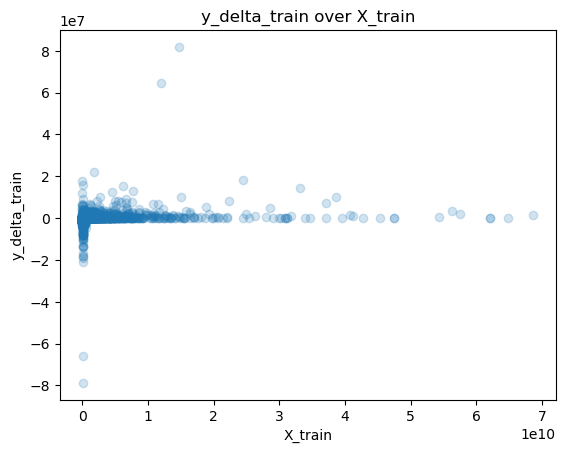

In [183]:
so4_indices = [0, 1, 2, 3, 4]
bc_indices = [5, 6, 7, 8]
oc_indices = [9, 10, 11, 12]
du_indices = [13, 14, 15, 16] 

selected_indices = so4_indices

N = 4000
random_indices = torch.randint(0, X_train_24.shape[0], (N,))

plt.scatter(X_train_24[np.ix_(random_indices, selected_indices)], y_delta_train_24[np.ix_(random_indices, selected_indices)], alpha = 0.2)
plt.xlabel('X_train')
plt.ylabel('y_delta_train')
plt.title('y_delta_train over X_train')

In [186]:
# np.set_printoptions(precision = 7, suppress = False, formatter = {'all': lambda x: f'{x:.7f}'})
# X_train_24[np.ix_(random_indices, selected_indices)]
# The value that looks like 0 is actually not that small

/tmp/ipykernel_168532/3421945778.py:12: RuntimeWarning: divide by zero encountered in log
  np.log(X_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/3421945778.py:12: RuntimeWarning: invalid value encountered in log
  np.log(X_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/3421945778.py:13: RuntimeWarning: divide by zero encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/3421945778.py:13: RuntimeWarning: invalid value encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),


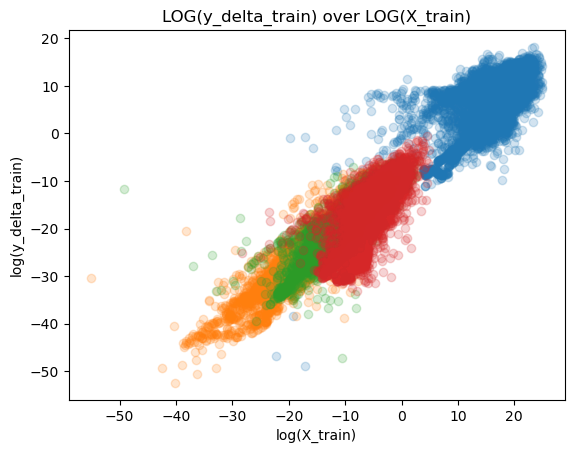

In [187]:
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

# It is a sample but this is quite telling!
for species, indices in species_indices.items():
    # logging both makes it much more linear!
    plt.scatter(
        np.log(X_train_24[np.ix_(random_indices, indices)]), 
        np.log(y_delta_train_24[np.ix_(random_indices, indices)]), 
        alpha = 0.2)

    plt.xlabel('log(X_train)')
    plt.ylabel('log(y_delta_train)')
    plt.title('LOG(y_delta_train) over LOG(X_train)')

/tmp/ipykernel_168532/2728503889.py:28: RuntimeWarning: divide by zero encountered in log
  np.log(X_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/2728503889.py:28: RuntimeWarning: invalid value encountered in log
  np.log(X_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/2728503889.py:29: RuntimeWarning: divide by zero encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/2728503889.py:29: RuntimeWarning: invalid value encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),


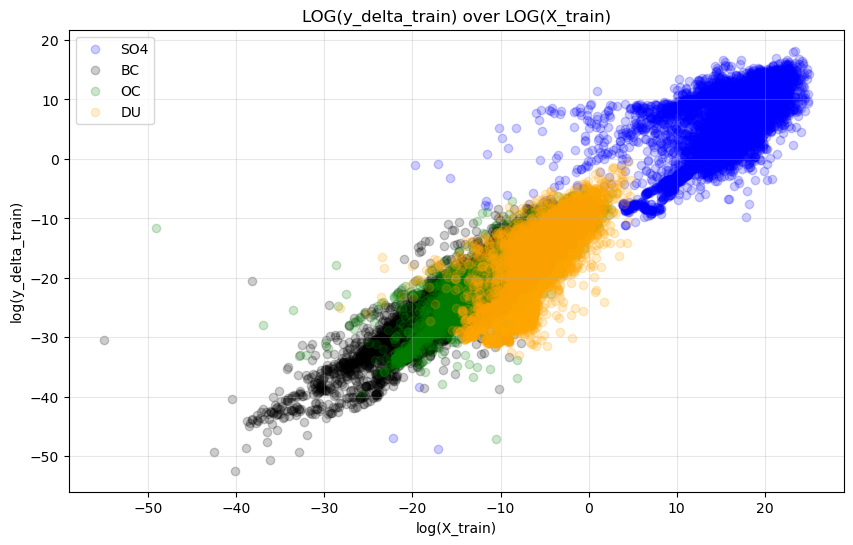

In [192]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define a color map for the different species
species_colors = {
    'so4': 'blue',
    'bc': 'black',
    'oc': 'green',
    'du': 'orange',
    'ss': 'red'  # I notice you have 5 columns but only 4 in your dict, added 'ss' as placeholder
}

# Your species indices
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
    # Add 'ss' indices if needed
}

plt.figure(figsize=(10, 6))

# Plot each species with its own color
for species, indices in species_indices.items():
    plt.scatter(
        np.log(X_train_24[np.ix_(random_indices, indices)]), 
        np.log(y_delta_train_24[np.ix_(random_indices, indices)]), 
        alpha=0.2,
        color=species_colors[species],
        label=species.upper()  # Add a label for the legend
    )

plt.xlabel('log(X_train)')
plt.ylabel('log(y_delta_train)')
plt.title('LOG(y_delta_train) over LOG(X_train)')
plt.legend()  # Add a legend to distinguish between species
plt.grid(True, alpha=0.3)  # Optional: adds a light grid for better readability

# If you want to save the figure
# plt.savefig('species_scatter_plot.png', dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_168532/1527051738.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(X_train_24[random_indices, idx]),
/tmp/ipykernel_168532/1527051738.py:18: RuntimeWarning: invalid value encountered in log
  np.log(X_train_24[random_indices, idx]),
/tmp/ipykernel_168532/1527051738.py:19: RuntimeWarning: divide by zero encountered in log
  np.log(y_delta_train_24[random_indices, idx]),
/tmp/ipykernel_168532/1527051738.py:19: RuntimeWarning: invalid value encountered in log
  np.log(y_delta_train_24[random_indices, idx]),


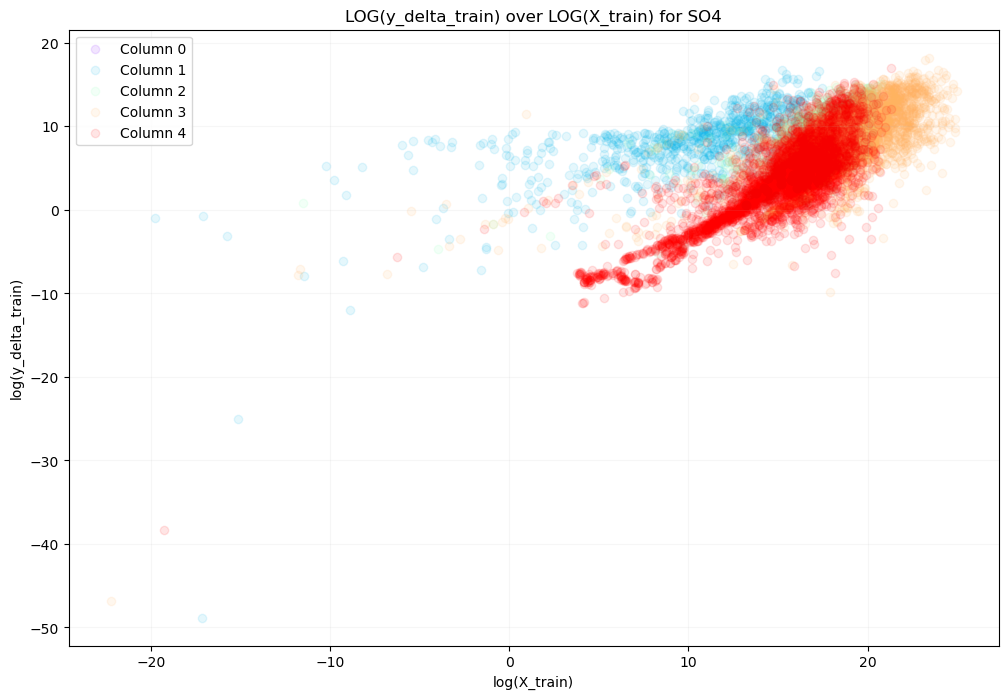

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Choose one species to work with, e.g., 'so4'
species = 'so4'
indices = species_indices[species]  # Get the indices for the chosen species

# Create a figure
plt.figure(figsize=(12, 8))

# Get a colormap with distinct colors
colors = cm.rainbow(np.linspace(0, 1, len(indices)))

# Plot each column with a different color
for i, idx in enumerate(indices):
    plt.scatter(
        np.log(X_train_24[random_indices, idx]), 
        np.log(y_delta_train_24[random_indices, idx]), 
        alpha = 0.1,
        color=colors[i],
        label=f'Column {idx}'  # You can replace with more descriptive labels if available
    )

plt.xlabel('log(X_train)')
plt.ylabel('log(y_delta_train)')
plt.title(f'LOG(y_delta_train) over LOG(X_train) for {species.upper()}')
plt.legend()
plt.grid(True, alpha = 0.1)

plt.show()

# Consider input within the context of the other inputs.

/tmp/ipykernel_168532/479813006.py:14: RuntimeWarning: divide by zero encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/479813006.py:14: RuntimeWarning: invalid value encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/479813006.py:13: RuntimeWarning: invalid value encountered in divide
  (X_train_24[np.ix_(random_indices, indices)]/ X_train_24[np.ix_(random_indices, indices)].sum(axis = 1, keepdims = True)),


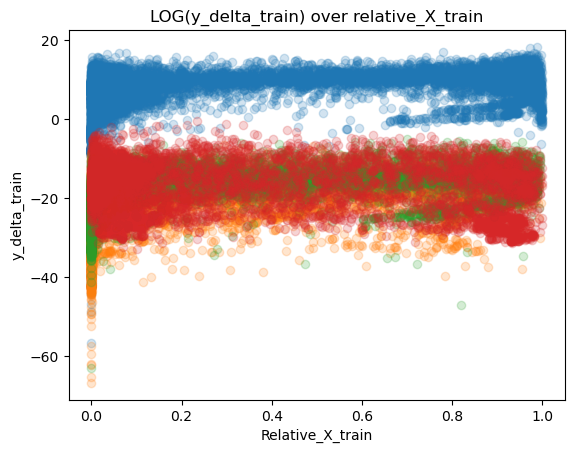

In [188]:
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

# It is a sample but this is quite telling!
for species, indices in species_indices.items():
    # logging both makes it much more linear!
    plt.scatter(
        # Uncorrelated with ralative
        (X_train_24[np.ix_(random_indices, indices)]/ X_train_24[np.ix_(random_indices, indices)].sum(axis = 1, keepdims = True)),
        np.log(y_delta_train_24[np.ix_(random_indices, indices)]), 
        alpha = 0.2)

    plt.xlabel('Relative_X_train')
    plt.ylabel('y_delta_train')
    plt.title('LOG(y_delta_train) over relative_X_train')

/tmp/ipykernel_168532/2924436166.py:14: RuntimeWarning: divide by zero encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),
/tmp/ipykernel_168532/2924436166.py:14: RuntimeWarning: invalid value encountered in log
  np.log(y_delta_train_24[np.ix_(random_indices, indices)]),


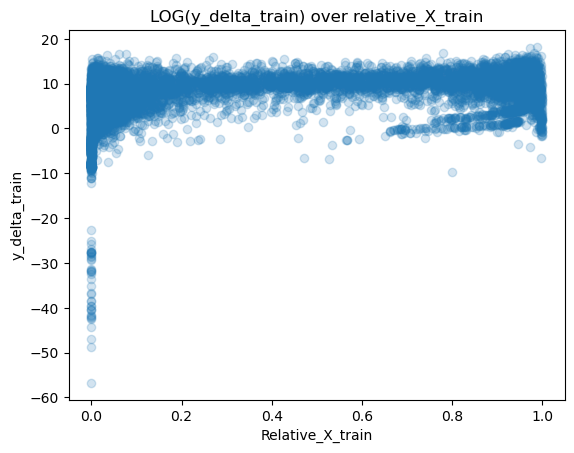

In [189]:
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

# It is a sample but this is quite telling!
for species, indices in species_indices.items():
    # logging both makes it much more linear!
    plt.scatter(
        # Uncorrelated with ralative
        (X_train_24[np.ix_(random_indices, indices)]/ X_train_24[np.ix_(random_indices, indices)].sum(axis = 1, keepdims = True)),
        np.log(y_delta_train_24[np.ix_(random_indices, indices)]), 
        alpha = 0.2)

    plt.xlabel('Relative_X_train')
    plt.ylabel('y_delta_train')
    plt.title('LOG(y_delta_train) over relative_X_train')
    break

/tmp/ipykernel_168532/2515021342.py:13: RuntimeWarning: divide by zero encountered in log
  (np.log(X_train_24[np.ix_(random_indices, indices)])),
/tmp/ipykernel_168532/2515021342.py:13: RuntimeWarning: invalid value encountered in log
  (np.log(X_train_24[np.ix_(random_indices, indices)])),


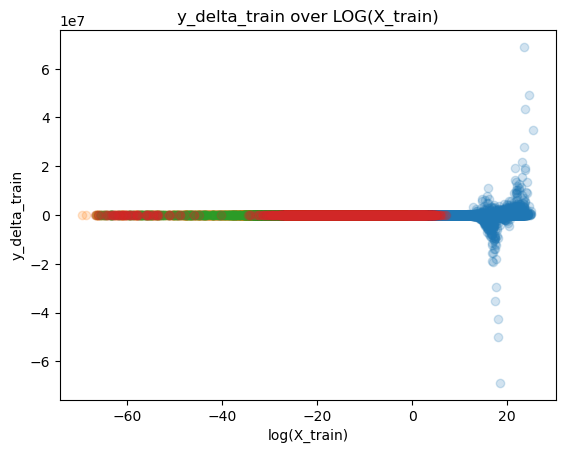

In [173]:
species_indices = {
    'so4': so4_indices,
    'bc': bc_indices,
    'oc': oc_indices,
    'du': du_indices
}

# It is a sample but this is quite telling!
for species, indices in species_indices.items():
    # logging both makes it much more linear!
    plt.scatter(
        # Uncorrelated with ralative
        (np.log(X_train_24[np.ix_(random_indices, indices)])),
        y_delta_train_24[np.ix_(random_indices, indices)], 
        alpha = 0.2)

    plt.xlabel('log(X_train)')
    plt.ylabel('y_delta_train')
    plt.title('y_delta_train over LOG(X_train)')

In [115]:
np.set_printoptions(precision = 7, suppress = True, formatter = {'all': lambda x: f'{x:.7f}'})

y_delta_train_24[np.ix_(random_indices, selected_indices)].min()

subset = y_delta_train_24[np.ix_(random_indices, selected_indices)]
min_index = np.unravel_index(np.argmin(subset), subset.shape)
print("Min value:", subset[min_index])
print("Index within subset:", min_index)

print(X_train_24[np.ix_([random_indices[min_index[0]].item()], selected_indices)])
print(y_train_24[np.ix_([random_indices[min_index[0]].item()], selected_indices)])
print("Delta:")
print(y_delta_train_24[np.ix_([random_indices[min_index[0]].item()], selected_indices)])

X_train_24[np.ix_([random_indices[min_index[0]].item()], selected_indices)] - y_train_24[np.ix_([random_indices[min_index[0]].item()], selected_indices)]

Min value: -78964206.16843173
Index within subset: (382, 0)
[[102590696.8408729 29763.0681812 200022895.7732856 16638789099.6861553
  171983233.6821681]]
[[23626490.6724412 33447.7524805 200227141.6760471 16717287523.1184616
  172241085.8312331]]
Delta:
[[-78964206.1684317 3684.6842993 204245.9027615 78498423.4323063
  257852.1490650]]


array([[78964206.1684317, -3684.6842993, -204245.9027615,
        -78498423.4323063, -257852.1490650]])

In [98]:
random_indices[2169].item()

4520825

In [ ]:
# NN outputs logits
logits = torch.tensor([2.0, 1.0, 0.5, 0.0, -1.0]).double()

# Compute softmax
softmax_output = torch.nn.functional.softmax(logits, dim = 0)
print("Softmax output:", softmax_output)

# Subtract the mean to make it sum to zero
softmax_zero_sum = softmax_output - torch.mean(softmax_output)
softmax_zero_sum * 10

Softmax output: tensor([0.5630, 0.2071, 0.1256, 0.0762, 0.0280], dtype=torch.float64)


tensor(-4.4409e-16, dtype=torch.float64)

In [62]:
transition_matrix = np.array([
    [0.9, 0.025, 0.05, 0.025, 0.0],
    [0.025, 0.9, 0.05, 0.025, 0.0],
    [0.0, 0.025, 0.9, 0.025, 0.05],
    [0.0, 0.025, 0.025, 0.9, 0.05],
    [0.0, 0.025, 0.05, 0.025, 0.9]])

result = transition_matrix @ X_train_24[i, [0, 1, 2, 3, 4]].reshape(-1, 1)

print(X_train_24[i, [0, 1, 2, 3, 4]].sum())
print(result.sum())

709607.2179026894
732570.1984326714


In [ ]:
sm = torch.tensor([0.9, 0.025, 0.05, 0.025, 0.0]).double()
zero_mean = sm - torch.mean(sm).double()
zero_mean
torch.log(sm + 1e-10)

tensor(-33.5047, dtype=torch.float64)

In [ ]:
log_output = torch.randn(5)
(torch.exp(log_output) - torch.mean(torch.exp(log_output)))

unconstrained = torch.randn(5)
out = unconstrained - torch.logsumexp(unconstrained, dim=0)

sm = torch.tensor([0.9, 0.025, 0.05, 0.025, 0.0])
torch.log(sm + 1e-10)

# what are valid solutions in the log space?
logit = torch.log(sm) - torch.log(1 - sm)

tensor([ 2.1972, -3.6636, -2.9444, -3.6636,    -inf])

In [33]:
tm = torch.tensor([
    [0.9, 0.025, 0.05, 0.025, 0.0],
    [0.025, 0.9, 0.05, 0.025, 0.0],
    [0.0, 0.025, 0.9, 0.025, 0.05],
    [0.0, 0.025, 0.025, 0.9, 0.05],
    [0.05, 0.025, 0.0, 0.025, 0.9]])

# row sum (collapses columns; dim is what is reduced)
print(tm.sum(dim = 1))
print(tm.mean(dim = 1))

# for 5 it is 0.2
mean_0_tm = tm - 1/tm.shape[-1]
print(mean_0_tm.mean(dim = 1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])
tensor([-2.9802e-09, -2.9802e-09, -8.9407e-09, -1.1921e-08, -1.1921e-08])


In [42]:
tm_zero_sum = tm - torch.eye(tm.shape[0])
tm_zero_sum

tensor([[-0.1000,  0.0250,  0.0500,  0.0250,  0.0000],
        [ 0.0250, -0.1000,  0.0500,  0.0250,  0.0000],
        [ 0.0000,  0.0250, -0.1000,  0.0250,  0.0500],
        [ 0.0000,  0.0250,  0.0250, -0.1000,  0.0500],
        [ 0.0500,  0.0250,  0.0000,  0.0250, -0.1000]])

# If we predict it directly we always have the issue with non-negativity!


In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ZeroSumNN(nn.Module):
    def __init__(self, input_dim=5):
        super(ZeroSumNN, self).__init__()
        
        # Simple feedforward network
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, input_dim)  # Output size = input size

    def forward(self, x):
        # Hidden layers with ReLU activation
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        raw_output = self.fc3(h)

        # Convert raw output into a zero-sum vector
        sm = F.softmax(raw_output, dim=1)  # Softmax ensures non-negative values
        zero_sum_output = sm - sm.mean(dim = 1, keepdim = True)  # Ensure sum is zero
        print("Zero-sum output:", zero_sum_output)
        print((zero_sum_output * 20).sum(dim = 1))

        # Ensuring non-negativity for X + delta by clamping delta
        delta = F.relu(zero_sum_output + x) - x  # ReLU to ensure non-negative outputs
        
        return delta

# Example usage
model = ZeroSumNN()
x_input = torch.tensor([[0.5, 0.3, 0.0, 0.4, 0.7]])  # Example input
delta_output = model(x_input)

print("Input X:", x_input)
print("Predicted Δ:", delta_output)
print("X + Δ (should be non-negative):", x_input + delta_output)
print("Sum of Δ (should be 0):", delta_output.sum(dim=1))

Zero-sum output: tensor([[ 0.0280,  0.0394,  0.0024, -0.0564, -0.0135]], grad_fn=<SubBackward0>)
tensor([-4.7684e-07], grad_fn=<SumBackward1>)
Input X: tensor([[0.5000, 0.3000, 0.0000, 0.4000, 0.7000]])
Predicted Δ: tensor([[ 0.0280,  0.0394,  0.0024, -0.0564, -0.0135]], grad_fn=<SubBackward0>)
X + Δ (should be non-negative): tensor([[0.5280, 0.3394, 0.0024, 0.3436, 0.6865]], grad_fn=<AddBackward0>)
Sum of Δ (should be 0): tensor([-4.4703e-08], grad_fn=<SumBackward1>)


In [35]:
mean_0_tm = tm - tm.mean(dim=1, keepdim=True)
print(mean_0_tm.mean(dim = 1))

tensor([ 8.9407e-09,  8.9407e-09,  5.9605e-09, -1.1921e-08,  1.1921e-08])


In [ ]:
class TransitionMM(nn.Module):
    def __init__(self, in_features, out_features, width, depth = 2, alpha = 0.999):
        super(TransitionMM, self).__init__()
        self.alpha = alpha
        self.out_features = out_features
        self.fc_in = nn.Linear(in_features = in_features, out_features = width)
        self.hidden_layers = nn.ModuleList()
        for i in range(depth -1):
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Linear(in_features = width, out_features = width))
            self.hidden_layers.append(nn.ReLU())
        # square output
        self.fc_out = nn.Linear(in_features = width, out_features = out_features)
    def forward(self, x):
        # Pass in relative values into the model as some normalisation
        # consider concating both
        x_norm = x / x.sum(axis = 1).unsqueeze(-1)
        state = self.fc_in(x_norm)
        for layer in self.hidden_layers:
            state = layer(state)
        state = self.fc_out(state)
        # Softmax adds to 1
        sm = F.softmax(state, dim = 1)
        # Convert to zero sum matrix
        # doule precision
        zero_sum = sm.double() - sm.mean(dim = 1, keepdim = True).double()
        # Currently range of this is limited. We can scale it!
        
        # Apply softmax across each columns to that columns (last dim) add to 1
        # tm is shape(batch_size, out_features, out_features)
        # Stabilise the transition matrix (nudge towards identity)
        stabiliser = torch.eye(tm.shape[-1]).repeat(tm.shape[0], 1, 1).to(tm.device)
        # Convex Combination of Transition Matrices is still a Transition Matrix
        stable_tm = self.alpha * stabiliser + (1 - self.alpha) * tm
        # x is shape(batch_size, in_features)
        out = torch.bmm(stable_tm, x.unsqueeze(-1)).squeeze(-1)
        # predict the delta (tendencies)
        y_delta = out - x
        return torch.log(y_delta)

0.2

# TM

- each row sums to 1
- The mean is 1 (probability mass) devided my N
- A vector with a mean of zero adds to 0!

In [23]:
size = 5
stabiliser = torch.full((size, size), 0.0)  # Fill with 0.1/4
torch.diagonal(stabiliser).fill_(1.0)
stabiliser

torch.eye(tm.shape[0])

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])

In [21]:
# ✅ 3. Convex Combination of Transition Matrices
alpha = 0.95
new_tm = alpha * stabiliser + (1 - alpha) * tm
new_tm

tensor([[0.9950, 0.0013, 0.0025, 0.0013, 0.0000],
        [0.0013, 0.9950, 0.0025, 0.0013, 0.0000],
        [0.0000, 0.0013, 0.9950, 0.0013, 0.0025],
        [0.0000, 0.0013, 0.0013, 0.9950, 0.0025],
        [0.0025, 0.0013, 0.0000, 0.0013, 0.9950]])

In [12]:
stabiliser

torch.mm(tm, stabiliser)

tensor([[0.9000, 0.0250, 0.0500, 0.0250, 0.0000],
        [0.0250, 0.9000, 0.0500, 0.0250, 0.0000],
        [0.0000, 0.0250, 0.9000, 0.0250, 0.0500],
        [0.0000, 0.0250, 0.0250, 0.9000, 0.0500],
        [0.0500, 0.0250, 0.0000, 0.0250, 0.9000]])

In [96]:
torch.set_printoptions(precision = 2, sci_mode = False)
inp = torch.tensor(X_train_24[i, [0, 1, 2, 3, 4]], dtype = torch.float32)

print(inp)
print(inp.sum())
print(inp @ tm)
print((inp @ tm).sum())
print(tm @ inp)
print((tm @ inp).sum())

tensor([   34.66,  1509.00, 306207.75, 401794.78,    61.05])
tensor(709607.25)
tensor([   71.97, 19060.55, 285709.03, 369310.62, 35455.07])
tensor(709607.25)
tensor([ 25424.18,  26714.22, 285672.62, 369311.25,  10139.27])
tensor(717261.50)


In [80]:
X_train_24[i, [0, 1, 2, 3, 4]].sum()

709607.2179026894

In [ ]:
# Check
so4_indices = [0, 1, 2, 3, 4]
bc_indices = [5, 6, 7, 8]
oc_indices = [9, 10, 11, 12]
du_indices = [13, 14, 15, 16] 
# consider order swap as in summary
# du_indices = [13, 16, 14, 15] 

# X_train_24[:, [0, 1, 2, 3, 4]].sum(axis = 1) - y_train_24[:, [0, 1, 2, 3, 4]].sum(axis = 1)
X_train_24_proportions = X_train_24[:, [0, 1, 2, 3, 4]] / X_train_24[:, [0, 1, 2, 3, 4]].sum(axis = 1)[..., np.newaxis]

array([[ 0.00002747,  0.00157305,  0.41735254,  0.58086694,  0.00017999],
       [ 0.00002747,  0.00157305,  0.41735254,  0.58086694,  0.00017999],
       [ 0.00002747,  0.00157305,  0.41735254,  0.58086694,  0.00017999],
       ...,
       [-0.        ,  0.00004815,  0.97397783,  0.02546609,  0.00050793],
       [-0.        ,  0.00004819,  0.97366943,  0.02576394,  0.00051844],
       [ 0.        ,  0.00004828,  0.97254076,  0.02685941,  0.00055154]])

In [ ]:
# [:, 0] first value is 1000 to 106209.9375, increases monotonically
# [:, 1] second value is 180 to 268
# [:, 2] third column is 0 to 1 (many 1s)
# [:, 3] fourth column is 0.95 to 40.5 (many 1s)
# [:, 4] fifth column is 0 to 1 (mostly 0s, many 1s)
# [:, 5] sixth column is 0 or 1 (manly 0s), nothing inbetween
# [:, 6] seventh column is 0 to 1 (many 0s)
# [:, 7] eighth column is very small values

array([7.00000000e+03, 2.12533646e+02, 7.18839243e-02, 1.83690460e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.15525649e-21,
       1.29102745e+05, 2.98289010e+01, 5.85955621e+06, 3.67345229e+08,
       1.20037845e+06, 4.62011533e-05, 1.30665184e-03, 2.09419851e-07,
       7.53481217e-09, 1.51886712e-04, 6.19863535e-03, 6.48942320e-07,
       2.67016086e-08, 3.80929956e-03, 2.17798216e-03, 2.91863057e-07,
       5.05673839e-06, 1.43374012e+00, 1.41705490e+01, 1.71655660e+01,
       9.95631738e-03, 2.82922001e-05, 1.83177483e-06, 6.29868841e-06])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# within args the default mode is train
def main(args):
    path_to_data = "/home/kim/data/aerosols/aerosol_emulation_data/"
    
    print('Loading data')    
    X_train = np.load(path_to_data + 'X_train.npy')
    y_train = np.load(path_to_data + 'y_train.npy')  
    
    if args.mode == 'train':
    # during training select validation as test data
        X_test = np.load(path_to_data + 'X_val.npy')
        y_test = np.load(path_to_data + 'y_val.npy')
    else:
        X_test = np.load(path_to_data + 'X_test.npy')
        y_test = np.load(path_to_data + 'y_test.npy')
    

    # Calculate tendencies (i.e. deltas)
    # THIS IS AN OVERWRITE
    # After this the y are deltas, not absolute values
    y_train[:, :24] -= X_train[:, 8:]
    y_test[:, :24] -= X_test[:, 8:]

    # Calculate stats
    # stats = calculate_stats(X_train, y_train, X_test, y_test, args)